# Section 11. GloVe

# 1. Recommender systems and matrix factorization

##### This is a brief detour, but when we move onto Glove it will be very clear why we did this first!
So whats the deal with recommender systems?
- Suppose you are Amazon and want to predict how much customer will like a product.
- You could frame it as a typical ML problem (ie you have set of user attributes and product attributes and combine into prediction model with USER RATINGS as labeled data)
- **But what if we want to learn PURELY from user ratings? Yes, and the answer is very related to PCA:**
    - **If one word row-vector looks like another word row-vector (eg. the word appears in the same documents a similar number of times), then these words are likely similar!!!**
    - So if two distinct words appear in a similar number of times in the same documents (or similar documents), then they are likely to have similar meaning!
    
We can apply some similar to movie ratings:  
<img src="pictures/NLP_11_movieratings.PNG">
- We see that one user likes a lot of the same movie as another user.
- So what if we didn't have some of these ratings? How do we will them in? **Matrix Factorization!**

### Matrix Factorization
- We pretend that the big original movie matrix exists in full (with NO empty spaces).
- We can model this big full matrix by saying its a product of two smaller matrices:
    - W (NxK): User matrix, each row represents a user
    - U.T (KxM): movie matrix, each row represents a movie 
        - **K: The rank**, the smaller dimension
- When you multiply the matrices together, you get back the FULL SIZE matrix:
    - A(NxM) ~= W(NxK).dot(U.T(KxM))
- Total parameters are N\*K + K\*M: ** But you want to choose a K thats just right, as too large and you will overfit, too little and you will have a crappy model.**
        
![](pictures/NLP_11_matrixfact.PNG)


### Prediction
Suppose we want to predict what a user 'i' has rated movie 'j':
- A(i,j) = Full movie matrix in row i (the user) and column j (the movie)
- A(i,j) = W(i).T.dot(U(j))

Careful here! if U is defined as K x M matrix, then:
- A ~ WU, and A(i,j) = W(i,:).T.dot(U(:,j) 

### Training
- Regression problem ---> squared error
- Cost function: J = ΣiΣj ( W(i)<sup>t</sup>U(j) - A(i,j) )<sup>2</sup> 
    - We can also treat A like a probability matrix and use KL-divergence
    - But we will stick to squarred errorr!
- i=1... N, j=1...M? NO!!! **Because we can only check the model for values that actually exist((**
- So we hope that A is full enough such that meaningful patterns can be found. 
- So we only train the model on existing data points (omega):
    - i,j ∈ Ω
    - Ω = set of all existing (i,j pairs)
- So the next step is to take the derivative and set it to 0
![](pictures/NLP_11_matfact.PNG)
- Just like we do with deep learning, we take the deriviative **with respect to each matrix one at a a time**. However, what we have here is a closed form solution!!! WOOOT!
- Be careful about the sums, we are only summing for the values for which A(i,j) is defined. 
    - Ωi means the set of all movies j that user i has rated
    - Ωj means the set of all users i who have rated movie j
- The tricky part here is invert the part where we have the dot product multiplied by a vector... And solving these two equations gets you U in terms of W, and W in terms of U, but **it doesnt solve for both!!!**.
- OMG WHAT DO WE DO!!!!

### Alternating Least Squares
- Because we have two unknowns, we loop through a number of epochs, and alternative between updating U and W
        for epoch in range(epochs):
            Update W
            Update U
- NOTE the proof is outside the scope of this lesson, but there is indeed a mathematical proof that guaruntees the cost will decrease after every update. Eventually you will fall into a **local BUT NOT global minimum**.             
- This is NOT gradient descent (we solved for W and U). We call this "alternating least squares" - we find the best W given the current U, then find the best U given the current W.
- This is mroe like the expectation algorithm than it is like GS, in the sense that we update one paramter to get the objective, while holding the other param constant.
- This is similar to K-means clustering, Guassian mixtures, Hidden markov Models
- NOTE: You CAN use gradient descent (which we will do later)... but it usually take more steps to settle into a minimum that ALS. 

### Adding Bias Terms
Now that we have the basics down, we want to add to the model to improve it. A good first option is bias terms, as per usual:

Bias terms:
- A(i,j) = W(i)<sup>T</sup>U(j) + b(i) + c(j) + μ
    - b(i): user bias (eg. if user i rates all movies high)
    - c(j): movies bias (eg. if everyone like Avatar)

- In matrix factorization, we usually have 2 or 3 (instead of just 1)
- There is a single scalar bias for each user, and a single scalar bias for each movie, so they will be of size n and m respectively
- You can think of a bias as an actual bias! If there is a dude who likes to troll, for instance, he will have a negative bias!
- Mu (μ) is the third bias here, which the global mean of the A matrix, which effectively centres the matrix around 0.
- Below are the updates wite the bias terms:
![](pictures/NLP_11_matfactadd.PNG)


### Regularization
- We have one left thing to add, regularization!
- We add this so that our cost doesnt explode to inifinity and it prevents us from OVERFITTING
- As usual, **its simply adding the frobenius norms (or euclidean norm) to the cost funciton with a hyperparameter λ to adjust its influence):**
![](pictures/NLP_11_mactfactreg.PNG)
- Solve for the derivatives by setting them to zero and find the parameter updates in closed form:
![](pictures/NLP_11_mactfactreg2.PNG)

### Summary
- We can create recommender systems by creating huge matrices with users along rows and movies along columns
- Different from usual ML problems because we are NOT using features, just existing ratings... We use existing rating to predict new ratings
- Model the big matrix as the product of 2 mall matrices
- Training: gradient descent or alternating least squares

# 2. GLoVe
### Overview of Glove
- Glove vectotrs for word representation is an alternative method to word2vec
- Its just some initial work up front, then its exactly like matrix factorization
- Similar to w2v, we are trying to incorporate context
- Will not build a term-document matrix like we did for w2v, but instead we will build a term-term matrix. 
- X(i,j) = higher if word(i) appears in context of word(j) oftern (and vice versa)
- With glove, its the details of how we build matrix X that are important, the rest is just simple matrix mactorization

### Building matrix X with "Context Distance"
- The main idea is that words get scored based on their distance to a target word. So in the sentence "I love dogs and cats", if word(i) = "I", then "love" gets a +1, dogs gets a +0.5, etc.
- Example: "I love dogs and cats": 
    - X(I, love) += 1
    - X(I, dogs) += 1/2
    - X(I, and) += 1/3
    - Et... up to a certian context size
- Remember that words frequencies have long tail distribution, so that means that we are going to have many zeros (this will be a very sparse matrix)
- Where we do have non-zero values, those values will be VERY large (even in the millions), depending on how many documents u have in corpus... 
- A common technique for scaling things down when they grow exponentially large is to take the log of those values, so thats what we do! 
    - **We can't take the log of 0, so we will add a 1 to every entry**
- log X(i,j) will be the target matrix!!!

### Cost function
We could construct a cost funciton from what we have so far, but we wont just yet... **Instead we will weight every (i,j)th entry by its X value.**
Reasearches have found this works well:*if its X value is sufficiently large, we will give it a weight of 1, if its X value is small we will give it a weight of less than 1.* The function used in the original paper is below:
- f(x) = (X/Xmax)<sup>α</sup> if X < Xmax, else 1
- α = 0.75
- Xmax = 100
- J = ΣiΣj f(Xij) (W(i)<sup>t</sup>U(j) - logXij)<sup>2</sup> 
- i=1...N, j=1...M? YES! **Because we dont have any missing values in this matrix. **

![](pictures/NLP_11_gloveJ.PNG)

### Solving the equation
- logXij ~= Wi<sup>T</sup>Uj + (b)i + (c)j + μ
- The original paper uses just 2 bias terms and gradient descent
- We will use 3 bias terms and Alternating Least squares (as well as GS)
- NOTE: Training time doesnt depend on the amount of data, you are always fitting to a VxV matrix (only the creation of X will take longer)
    - These derivatives are actually easier to solve for because you don't have to consider the set of values you have to consider under the summation (there are no missing values, unlike in our recomennder system example)
- Here are the gradients:
![](pictures/NLP_11_glovegrad.PNG)
![](pictures/NLP_11_glovegrad2.PNG)

# Lets write some Code!
- First we will write Glove using Gradient descent
- Then we will add in Alternating Least Squares

# 1. Import packages

In [6]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
import tensorflow as tf

# Import custom get_setnces: make sure custom script is in same folder as j notebook
from nltk.corpus import brown
from MC_NLP_util import get_sentences_with_word2idx_limit_vocab
from MC_NLP_util import find_analogies

# 2. Define Glove Class
- define 'fit' method
    - build in options for Gradient Descent or Alternating Least Squares
    - for GS option, build-in option to use TensorFlow or numpy
- define 'save' method so save model

In [36]:
#create Glove class
class Glove:
    def __init__(self, D, V, context_size):
        self.D = D
        self.V = V
        self.context_size = context_size
    
    def fit(self, sentences, cc_matrix_filepath="MC_cc_matrix.npy", learning_rate=1e-4,
            reg=0.1, ccmax=100, alpha=0.75, epochs=10, 
            gd=False, use_tensorflow=False, momentum=0.9):
        
        # INITIALIZE VARIABLES
        t0 = datetime.now()
        V = self.V
        D = self.D
        N_sents = len(sentences)
        
        # PRELOD CO-OCCURRENCE MATRIX IF EXISTS
        if os.path.exists(cc_matrix_filepath):
            print("Loading pretrained co-occurrence matrix: ", cc_matrix_filepath)
            cc_matrix = np.load(cc_matrix_filepath)
        # CREATE NEW CO-OCCURRENCE MATRIX
        else:            
            cc_matrix = np.zeros((V,V))
            print("Creating co-occurrence matrix\nNumber of sentences to process: ", N_sents)  
            # LOOP THROUGH EACH SENTENCE
            iteration = 0
            for sentence in sentences:
                iteration += 1
                if iteration % 10000 == 0:
                    print("Processed {} of {} sentences".format(iteration,N_sents))
                # LOOP THROUGH EACH WORD IN SENTENCE
                len_sent = len(sentence)
                for word_idx in range(len_sent):
                    # NOTE: word_idx is NOT the matrix word index
                    # ...it is only the within-sentence index
                    # ie. it points to which element of the sequence (sentence) we're looking at
                    # wi is target word
                    wi = sentence[word_idx]
                    # EXTRACT CONTEXT
                    start = max(0, word_idx - self.context_size)
                    end = min(len_sent, word_idx + self.context_size)
                    # NOTE: We can choose either 1 side of context or both
                    # Here we will use both side of the context
                    # MAKE SURE START AND END TOKENS ARE PART OF SOME CONTEXT
                    # otherwise their f(x) will be 0 (denominator in bias update)
                    if word_idx - self.context_size < 0:
                        # Start tokens get assigned points because they are in the context
                        # word_idx+1 is min (context size is truncated)
                        points = 1.0 / (word_idx + 1)
                        cc_matrix[wi,0] += points
                        cc_matrix[0,wi] += points
                    if word_idx + self.context_size > len_sent:
                        points = 1.0 / (len_sent - word_idx)
                        # End tokens get assigned points because they are in context 
                        # len_sent-word_idx is context length (context size is truncated) 
                        cc_matrix[wi,1] += points
                        cc_matrix[1,wi] += points 
                    # UPDATE LEFT SIDE OF TARGET WORD
                    for j in range(start, word_idx): # exclusive, as we want to exclude target word_idx
                        wj = sentence[j]
                        # Points increase as j gets closer to word index
                        # Ie. words right next to target are scored hire
                        points = 1.0/(word_idx-j)
                        cc_matrix[wi,wj] += points
                        cc_matrix[wj,wi] += points
                    # UPDATE RIGHT SIDE OF TARGET WORD
                    for j in range (word_idx+1, end): 
                        wj = sentence[j]
                        points = 1.0/(j-word_idx)
                        #cc_matrix[wi,wj] += points
                        #cc_matrix[wj,wi] += points
            np.save(cc_matrix_filepath, cc_matrix)
        
        # PRINT OUT MAXIMUM VALUE
        print("Max in cc_matrix:", cc_matrix.max())
        
        # EXTRACT AND APPLY WEIGHTING
        fX = np.zeros((V,V))
        # If less than ccmax threshold (100), new_val = (orig_val/ccmax)^alpha
        fX[cc_matrix < ccmax] = (cc_matrix[cc_matrix < ccmax] / float(ccmax))**alpha
        # If greater than ccmax, new_val = 1
        fX[cc_matrix >= ccmax] = 1
        print("Max in f(cc_matrix):", fX.max())
        
        # EXTRACT TARGET (log of cc_matrix, add 1 so no zeros)
        logCC = np.log(cc_matrix +1)
        print("Max in log(cc_matrix): ", logCC.max())
        print("Time to build co-occurrence matrix:", datetime.now() - t0)
        
        # INITIALIZE WEIGHTS
        W = np.random.rand(V, D) / np.sqrt(V + D)
        U = np.random.rand(V, D) / np.sqrt(V + D)
        b = np.zeros(V)
        c = np.zeros(V)
        mu = logCC.mean()
        
        # CREATE TENSORFLOW GRAPH
        if use_tensorflow:
            # Create tf variables with np.arrays
            tf_W = tf.Variable(W.astype(np.float32))
            tf_U = tf.Variable(U.astype(np.float32))
            tf_b = tf.Variable(b.reshape(V, 1).astype(np.float32))
            tf_c = tf.Variable(b.reshape(1, V).astype(np.float32))
            tf_fX = tf.placeholder(tf.float32, shape=(V,V))
            tf_logCC = tf.placeholder(tf.float32, shape=(V,V))
            
            # Calcuate cost
            delta = (tf.matmul(tf_W, tf.transpose(tf_U))+ tf_b + tf_c + mu) - tf_logCC
            cost = tf.reduce_sum(tf_fX * delta*delta)
            
            # Add regularization to cost
            for param in (tf_W, tf_b, tf_U, tf_c ):
                cost += reg*tf.reduce_sum(param*param)
            
            # Set training op (Use the momentum optimizer)
            train_op = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum).minimize(cost)
            
            # Initialize variables
            init = tf.global_variables_initializer()
            session = tf.InteractiveSession()
            session.run(init)
        
        # RUN MODEL AND PRINT COST
        costs = []
        sentences_idxs = range(N_sents)
        for epoch in range(epochs):
            te0 = datetime.now()
            delta = W.dot(U.T) + b.reshape(V, 1) + c.reshape(1, V) + mu - logCC
            cost = (fX * delta *  delta).sum()
            costs.append(cost)
            print("Epoch:",epoch,"Cost:",cost)
            
            # RUN MODEL MODEL WITH GRADIENT DESCENT
            if gd:
                # Train model with tensorflow
                if use_tensorflow:
                    session.run(train_op, feed_dict={tf_logCC: logCC, tf_fX: fX})
                    # Update weights to be fed into cost function
                    W,U,b,c = session.run([tf_W,tf_U,tf_b,tf_c])
                # Train model with numpy
                else:
                    oldW = W.copy()
                    # UPDATE W
                    for i in range(V):
                        # FULL CODE FOR W UPDATE (NON VECTORIZED)
                        # for j in range(V)
                        #     W[i] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logCC[i,j])*U[j]
                        W[i] -= learning_rate*(fX[i,:]*delta[i,:]).dot(U)
                    W -= learning_rate*reg*W
                    
                    # UPDATE b
                    for i in range(V):
                        # FULL CODE FOR b UPDATE (NON VECTORIZED)
                        # for j in range(V)
                        #     b[i] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logCC[i,j])
                        b[i] -= learning_rate*fX[i,:].dot(delta[i,:])
                    b -= learning_rate*reg*b
                    
                    # UPDATE U
                    for j in range(V):
                        # FULL CODE FOR U UPDATE (NON VECTORIZED)
                        # for i in range(V)
                        #     U[j] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logCC[i,j])*W[j]
                        U[j] -= learning_rate*(fX[:,j]*delta[:,j]).dot(oldW)
                    U -= learning_rate*reg*U
                    
                    # UPDATE c
                    for j in range(V):
                        # FULL CODE FOR c UPDATE (NON VECTORIZED)
                        # for i in range(V)
                        #     c[i] -= learning_rate*fX[i,j]*(W[i].dot(U[j]) + b[i] + c[j] + mu - logCC[i,j])
                        c[i] -= learning_rate*fX[:,j].dot(delta[:,j])
                    c -= learning_rate*reg*c
            else:
                # RUN ALTERNATING LEAST SQUARES (ALS)
                for i in range(V):
                    # matrix = reg*np.eye(D) + np.sum((fX[i,j]*np.outer(U[j], U[j]) for j in range(V)), axis=0)
                    matrix = reg*np.eye(D) + (fX[i,:]*U.T).dot(U)
                    # assert(np.abs(matrix - matrix2).sum() < 1e-5)
                    vector = (fX[i,:]*(logCC[i,:] - b[i] - c - mu)).dot(U)
                    #SOLVE TO GET UPDATED WEIGHTS
                    W[i] = np.linalg.solve(matrix, vector)
                # print "fast way took:", (datetime.now() - t0)

                # slow way
                # t0 = datetime.now()
                # for i in range(V):
                #     matrix2 = reg*np.eye(D)
                #     vector2 = 0
                #     for j in range(V):
                #         matrix2 += fX[i,j]*np.outer(U[j], U[j])
                #         vector2 += fX[i,j]*(logX[i,j] - b[i] - c[j])*U[j]
                # print "slow way took:", (datetime.now() - t0)

                    # assert(np.abs(matrix - matrix2).sum() < 1e-5)
                    # assert(np.abs(vector - vector2).sum() < 1e-5)
                    # W[i] = np.linalg.solve(matrix, vector)
                # print "updated W"

                # update b
                for i in range(V):
                    denominator = fX[i,:].sum()
                    # assert(denominator > 0)
                    numerator = fX[i,:].dot(logCC[i,:] - W[i].dot(U.T) - c - mu)
                    # for j in range(V):
                    #     numerator += fX[i,j]*(logX[i,j] - W[i].dot(U[j]) - c[j])
                    b[i] = numerator / denominator / (1 + reg)
                # print "updated b"

                # update U
                for j in range(V):
                    # matrix = reg*np.eye(D) + np.sum((fX[i,j]*np.outer(W[i], W[i]) for i in range(V)), axis=0)
                    matrix = reg*np.eye(D) + (fX[:,j]*W.T).dot(W)
                    # assert(np.abs(matrix - matrix2).sum() < 1e-8)
                    vector = (fX[:,j]*(logCC[:,j] - b - c[j] - mu)).dot(W)
                    # matrix = reg*np.eye(D)
                    # vector = 0
                    # for i in range(V):
                    #     matrix += fX[i,j]*np.outer(W[i], W[i])
                    #     vector += fX[i,j]*(logX[i,j] - b[i] - c[j])*W[i]
                    #SOLVE TO GET UPDATED WEIGHTS
                    U[j] = np.linalg.solve(matrix, vector)
                # print "updated U"

                # update c
                for j in range(V):
                    denominator = fX[:,j].sum()
                    numerator = fX[:,j].dot(logCC[:,j] - W.dot(U[j]) - b  - mu)
                    # for i in range(V):
                    #     numerator += fX[i,j]*(logX[i,j] - W[i].dot(U[j]) - b[i])
                    c[j] = numerator / denominator / (1 + reg)
                # print "updated c"
            print("Epoch {} complete. Total runtime: {}".format(epoch, datetime.now()-te0))
        
        # STORE FINAL WEIGHTS
        self.W = W
        self.U = U
        plt.plot(costs)
        plt.show()
        
    def save(self, filename):
        # word_analogies function expects a (V,D) matrix and a (D,V) matrix
        arrays = [self.W, self.U.T]
        np.savez(filename, arrays)

# 3. Get Data & Run Model

In [40]:
# SET FILENAME VARIABLES FOR REUSING MODEL LATER (without re-training)
w2i_file = "data/glove_mod_w2i.json"
ccmat_file = "data/glove_mod_ccmat.npy"
mod_file = "data/glove_mod_ccmat.npy"

# EXTRACT DATA
keep_these = set(['king', 'man', 'woman',
    'france', 'paris', 'london', 'rome', 'italy', 'britain', 'england',
    'french', 'english', 'japan', 'japanese', 'chinese', 'italian',
    'december', 'november', 'june',
    'january', 'february', 'march', 'april', 'may', 'july', 'august',
    'september', 'october'])
sentences, word2idx = get_sentences_with_word2idx_limit_vocab(n_vocab=1000000, n_sent=10000, keep_words=keep_these)
V = len(word2idx)

# SAVE W2I
with open(w2i_file, 'w') as f:
    json.dump(word2idx, f) 

Sentences:  9948
Vocab:  21142


Creating co-occurrence matrix
Number of sentences to process:  9948
Max in cc_matrix: 8595.0
Max in f(cc_matrix): 1.0
Max in log(cc_matrix):  9.059052257762401
Time to build co-occurrence matrix: 0:00:31.491985
Epoch: 0 Cost: 65368.65424737293
Epoch 0 complete. Total runtime: 0:01:27.662767
Epoch: 1 Cost: 57989.30525081883
Epoch 1 complete. Total runtime: 0:00:55.575133
Epoch: 2 Cost: 47092.91994398284
Epoch 2 complete. Total runtime: 0:00:55.570270
Epoch: 3 Cost: 37192.71370454042
Epoch 3 complete. Total runtime: 0:00:57.498879
Epoch: 4 Cost: 31198.847419590387
Epoch 4 complete. Total runtime: 0:00:57.554651
Epoch: 5 Cost: 29466.371746384193
Epoch 5 complete. Total runtime: 0:01:03.757694
Epoch: 6 Cost: 30338.275119140842
Epoch 6 complete. Total runtime: 0:01:03.355964
Epoch: 7 Cost: 31548.88836428528
Epoch 7 complete. Total runtime: 0:01:01.488436
Epoch: 8 Cost: 31544.551551457676
Epoch 8 complete. Total runtime: 0:01:01.011007
Epoch: 9 Cost: 30050.309499621984
Epoch 9 complete. Tota

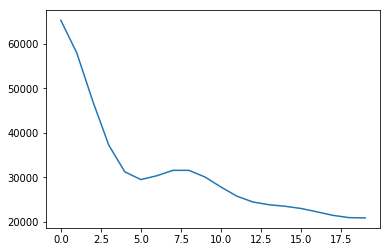

In [42]:
# RUN MODEL
glove_mod = Glove(100, V, 10)
glove_mod.fit(sentences,cc_matrix_filepath='', gd=True, use_tensorflow=True, epochs=20)

# 4. Test Word Analogies


In [69]:
# LOAD DATA
W1 = glove_mod.W
W2 = glove_mod.U

In [71]:
with open(w2i_file) as f:
    word2idx = json.load(f)
print("W1 shape:",W1.shape)
print("W2.T shape:",W2.T.shape)

# CONCAT WORD VECTORS
W_embs = (W1+W2)/2
print("Word embeddings shape:", W_embs.shape)
print("Word2idx shape:", len(word2idx))

W1 shape: (21142, 100)
W2.T shape: (100, 21142)
Word embeddings shape: (21142, 100)
Word2idx shape: 21142


In [72]:
# Find word analogies!
find_analogies('king','man','woman',W_embs,word2idx)
find_analogies('queen','woman','man',W_embs,word2idx)

closest match by Euclidean distance: hailed
king - man = hailed - woman 

closest match by cosine distance: marines
king - man = marines - woman 

closest match by Euclidean distance: two
queen - woman = two - man 

closest match by cosine distance: a
queen - woman = a - man 



So these are clearly some pretty crappy word vectors... But this is to be expected. This was more of an exercise to implement your own Glove algo, which was done succesffuly!